In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Carga los datos
df = pd.read_csv('dataset.csv')

df

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,ed6a3fc04af435176b9c2f3024eb53c31d1e522da52c5c...,1,CreateToolhelp32Snapshot,GetCursorPos,CoUninitialize,RegCloseKey,LdrUnloadDll,DrawTextExW,NtSetInformationFile,CopyFileA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,ed5d70a13633a46355c0c2f9905ba29b7b74dfdb4db321...,1,NtDuplicateObject,RegCloseKey,LdrUnloadDll,NtSetInformationFile,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,ed5addbdbe5f56f108530148c71ab7db806ac9324395d0...,1,GetCursorPos,NtOpenSection,CoUninitialize,RegCloseKey,LdrUnloadDll,GetSystemInfo,RegQueryValueExA,NtTerminateProcess,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,ed4f4518e3120a4fd8ff6c61bf072d4de60264711a9196...,1,NtAllocateVirtualMemory,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetFileType,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetDllHandle,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preprocesamiento y tranformación de los datos del dataset

In [21]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# Concatenando las columnas de las secuencias de llamadas a las API en una sola columna
df['sequence'] = df[df.columns[2:]].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Preprocesamiento de los datos
sent = [row.split() for row in df['sequence']]

# Creando frases relevantes de las listas de palabras en las secuencias
phrases = Phrases(sent, min_count=30, progress_per=10000)

# Transformando el corpus basado en las frases detectadas
sentences = phrases[sent]

# Creando un modelo Word2Vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

# Construyendo el vocabulario
w2v_model.build_vocab(sentences, progress_per=10000)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

# Obtieniendo las etiquetas
y = df['labels']

# Eliminando las columnas originales de las secuencias de llamadas a las API
df = df.drop(df.columns[2:-1], axis=1)

df['vector'] = df['sequence'].apply(lambda x: np.mean([w2v_model.wv[word] for word in x.split() if word in w2v_model.wv], axis=0))

# Escribiendo el DataFrame limpio en un archivo CSV
df.to_csv("dataset_clean.csv", index=False)

Creando los modelos de clasificación

Abriendo el nuevo dataset

In [22]:
df2 = pd.read_csv('dataset_clean.csv')

Diviediendo los datos en entrenamiento y prueba

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['vector'].tolist(), y, test_size=0.3, random_state=42)

Regresión logística

Reporte de Clasificación para el modelo de Regresión Logística:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       380
           1       0.95      0.91      0.93       391

    accuracy                           0.93       771
   macro avg       0.93      0.93      0.93       771
weighted avg       0.93      0.93      0.93       771

Validación cruzada para el modelo de Regresión Logística:


0.88715953307393


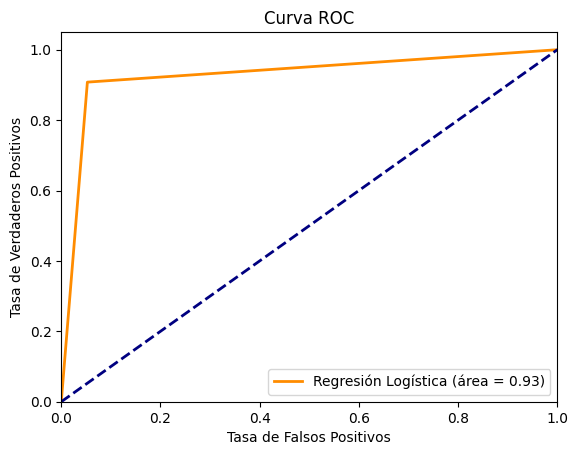

In [24]:
# Modelo de Regresión Logística
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predicciones con el modelo de Regresión Logística
y_pred_lr = lr.predict(X_test)

print("Reporte de Clasificación para el modelo de Regresión Logística:")
print(classification_report(y_test, y_pred_lr))

# Validación cruzada con K folds para k = 10
kf = KFold(n_splits=10)

print("Validación cruzada para el modelo de Regresión Logística:")
print(cross_val_score(lr, df['vector'].tolist(), y, cv=kf).mean())

# Cálculo y explicación de las métricas de Accuracy, Precision , Recall y curva ROC para ambas clases (benigno, malware)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Regresión Logística (área = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Random forest

Reporte de Clasificación para el modelo de Bosques Aleatorios:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       380
           1       0.97      0.94      0.95       391

    accuracy                           0.95       771
   macro avg       0.95      0.95      0.95       771
weighted avg       0.96      0.95      0.95       771

Validación cruzada para el modelo de Bosques Aleatorios:
0.9431906614785992


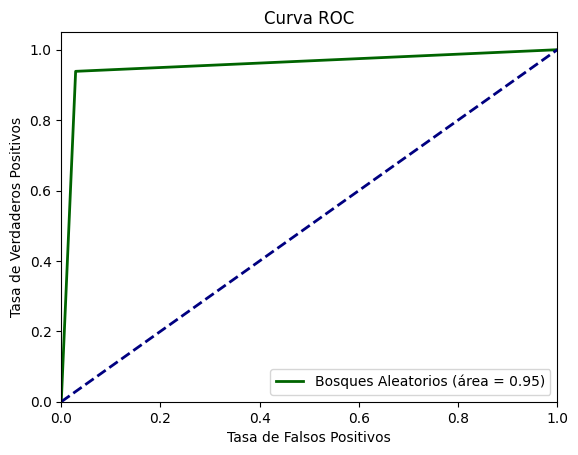

In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predicciones con el modelo de Bosques Aleatorios
y_pred_rf = rf.predict(X_test)

print("Reporte de Clasificación para el modelo de Bosques Aleatorios:")
print(classification_report(y_test, y_pred_rf))

# Validación cruzada con K folds para k = 10
kf = KFold(n_splits=10)

print("Validación cruzada para el modelo de Bosques Aleatorios:")
print(cross_val_score(rf, df['vector'].tolist(), y, cv=kf).mean())

# Cálculo y explicación de las métricas de Accuracy, Precision , Recall y curva ROC para ambas clases (benigno, malware)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label='Bosques Aleatorios (área = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()